# Kuvantunnistus omista kuvista
Tunnistetaan kuvia aterimista

In [3]:
# Importit
from keras.utils import to_categorical, image_dataset_from_directory
import pandas as pd
import keras.layers as layers
from keras import models
from keras import callbacks
from keras import optimizers
from keras import regularizers
from keras.preprocessing import image
import os
import shutil
import random

Aluksi rajataan kuvat omiin kansioihinsa

In [4]:
import os
import shutil
import random

# Define paths
input_folder = 'OriginalPhotos'  # Source folder containing images
output_folder = 'DatasetSplit'  # Destination folder for train/val/test split

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure output folders exist
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_folder, split), exist_ok=True)

# Function to copy files while maintaining folder structure
def split_images(input_folder, output_folder, train_ratio, val_ratio, test_ratio):
    for root, dirs, files in os.walk(input_folder):
        if not files:  # Skip directories without files
            continue

        # Get relative path to preserve folder structure
        relative_path = os.path.relpath(root, input_folder)

        # Create corresponding subfolders in train, val, and test
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(output_folder, split, relative_path), exist_ok=True)

        # Shuffle files to randomize the split
        random.shuffle(files)

        # Calculate split indices
        total_files = len(files)
        train_end = int(total_files * train_ratio)
        val_end = train_end + int(total_files * val_ratio)

        # Split files into train, val, and test
        train_files = files[:train_end]
        val_files = files[train_end:val_end]
        test_files = files[val_end:]

        # Copy files to respective folders
        for file in train_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'train', relative_path, file))
        for file in val_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'val', relative_path, file))
        for file in test_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'test', relative_path, file))

# Call the function
split_images(input_folder, output_folder, train_ratio, val_ratio, test_ratio)

print(f"Images have been split into train, validation, and test folders in '{output_folder}'")

Images have been split into train, validation, and test folders in 'DatasetSplit'


Tuodaan ja valmistellaan kuvat
- Augment data
- Luokitellaan kuvat
- Laitetaan kuvat datasettiin

In [ ]:
imgSize = 64
imgPath = 'OriginalPhotos'
batchSize = 4

# Kopioi kuvat testi, train ja val kansioihin
# Testiin menee 20% kuvista, ja 80% menee train kansioon
# Jaetaan data 80/20 train/val


# Haetaan kuvat kansiosta ja luodaan DataFrame
train_dataset, val_dataset = image_dataset_from_directory(
    directory=imgPath,
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
    color_mode="rgb",
    shuffle=True,
    seed=42,
    validation_split=0.2,  # Reserve 20% of data for validation
    subset="both"
)

# TODO: Testi dataset (esim. erikseen kansio, jossa on testikuvat, jotka ei ole muiden kuvien seassa)
classNames = train_dataset.class_names
print('Class names: ', classNames)
classesAmount = len(train_dataset.class_names)

# Rescaling layer
rescale = Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (rescale(x), y))
val_dataset = val_dataset.map(lambda x, y: (rescale(x), y))

Found 32 files belonging to 2 classes.
Using 26 files for training.
Using 6 files for validation.


Class names:  ['Haarukat', 'Lusikat']


Mallin koulutus ja testaus

In [105]:
l2Reg = regularizers.l2(0.01)

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.2),
])

# Fix the batch dimension issue by unbatching and then rebatching
train_dataset = train_dataset.unbatch()
val_dataset = val_dataset.unbatch()

# Correctly rebatch the datasets
train_dataset = train_dataset.batch(batchSize)
val_dataset = val_dataset.batch(batchSize)

model = models.Sequential([
    Input(shape=(imgSize, imgSize, 3)),

    data_augmentation,

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2Reg),
    Dropout(0.4),

    Dense(classesAmount, activation='softmax')  # Output layer
])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15,
    restore_best_weights=True
)

seOptimizer = optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=seOptimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Koulutetaan malli
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    verbose=1,
    callbacks=[early_stopping]
)

print("Koulutus valmis!")
print("Accuracy: ", history.history['accuracy'][-1])
print("Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Loss: ", history.history['loss'][-1])
print("Validation Loss: ", history.history['val_loss'][-1])

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_52 (Sequential)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,354 (2.61 MB)

 Trainable params: 683,906 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/200
      5/Unknown 3s 17ms/step - accuracy: 0.6758 - loss: 4.9594

c:\Users\tatus\anaconda3\envs\seToinenEnvi\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6692 - loss: 5.3621 - val_accuracy: 0.6667 - val_loss: 4.3709
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4641 - loss: 6.7914 - val_accuracy: 0.3333 - val_loss: 4.4085
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4766 - loss: 5.5434 - val_accuracy: 0.3333 - val_loss: 4.3767
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3479 - loss: 6.0666 - val_accuracy: 0.3333 - val_loss: 4.3884
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7226 - loss: 4.4685 - val_accuracy: 0.3333 - val_loss: 4.3832
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6989 - loss: 4.7310 - val_accuracy: 0.3333 - val_loss: 4.4591
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6049 - loss: 4.8092 - val_accuracy: 0.3333 - val_loss: 4.6318
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7053 - loss: 4.5853 - val_accuracy: 0.5000 - val_loss: 4.2998
Epoc

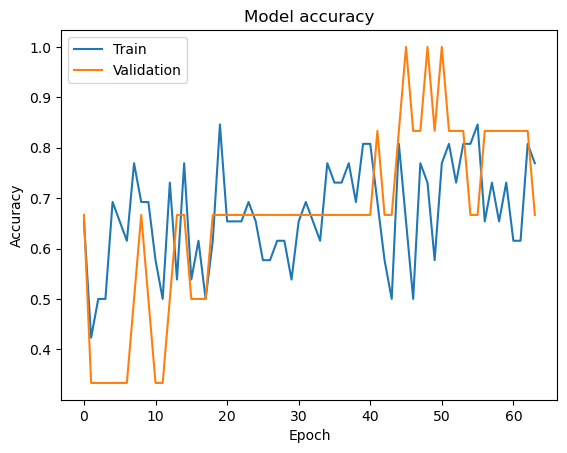

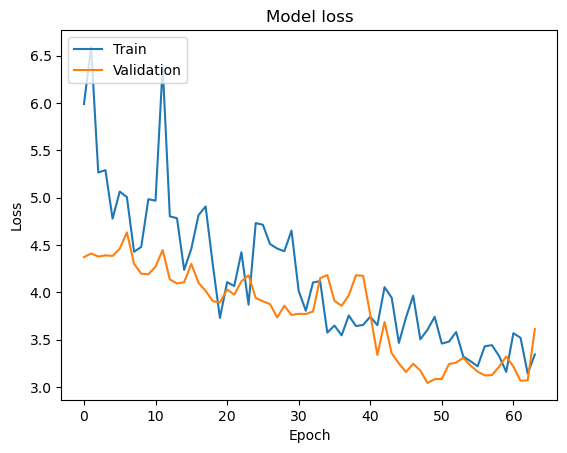

In [106]:
# Näytetään mallin treenihistoria
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()